In [23]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Aer, transpile
from qiskit.visualization import plot_histogram

In [28]:
class QPP:
    def __init__(self, *args):
        self.total_qubits = len(args)
        
        self.phase_qubit = AncillaRegister(1, name="ancilla")
        self.classical_bits = ClassicalRegister(self.total_qubits, name="out") 
        self.circuit = QuantumCircuit(self.phase_qubit, *args, self.classical_bits)
        self.backend = Aer.get_backend("aer_simulator")
    
    def add_input(self, bit_string):
        assert len(bit_string) == self.total_qubits, "Different amount of registers" 
    
        for qubit, bit in enumerate(bit_string[::-1]):
            if(bit == '1'):
                self.circuit.x(qubit+1)
        self.add_barrier()
    
    def add_barrier(self):
        self.circuit.barrier()
    
    def prepare(self, bit_string, show_oracle=False):
        self.add_oracle(bit_string, show_oracle)
        self.add_measurement()
    
            
    def add_oracle(self, bit_string, show_oracle):
        assert len(bit_string) <= self.total_qubits, "Different amount of registers" 
        
        bit_string = bit_string[::-1]
        total_oracle_qubits = self.total_qubits+1
        qubits_iterator = range(total_oracle_qubits)
        
        oracle = QuantumCircuit(total_oracle_qubits, name="Oracle")
        
        oracle.x(0)
        oracle.h(qubits_iterator)
        
        for qubit in range(1, total_oracle_qubits): 
            if(bit_string[qubit-1] == '1'):
                oracle.cx(qubit, 0)
                
        oracle.h(qubits_iterator)
        
        if(show_oracle): 
            display(oracle.draw('mpl'))
        
        self.circuit.append(oracle, qubits_iterator)
        
    def add_measurement(self):
        self.circuit.measure(range(1, self.total_qubits+1), range(self.total_qubits))
    
    def measure(self):
        transpiled_circuit = transpile(self.circuit, self.backend)
        results = self.backend.run(transpiled_circuit, shots=1000).result().get_counts()
        display(plot_histogram(results))
    
    def show(self):
        display(self.circuit.draw("mpl"))
        

In [29]:
all_documents = QuantumRegister(1, name="documents")
false_info = QuantumRegister(1, name="falsification")
wanted = QuantumRegister(1, name="wanted")
bribe = QuantumRegister(1, name="bribe")

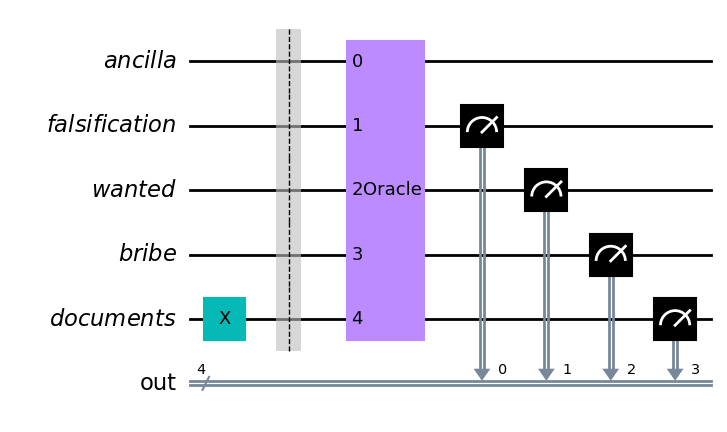

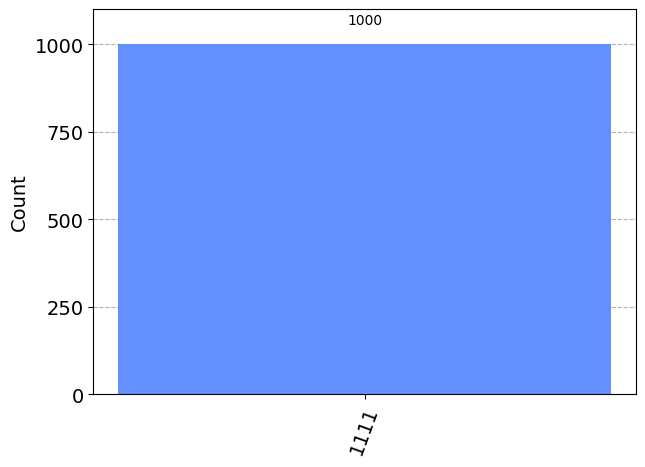

In [30]:
algorithm = QPP(false_info, wanted, bribe, all_documents)
algorithm.add_input("1000")
algorithm.prepare(bit_string="0111", show_oracle=False)
algorithm.show()
algorithm.measure()